In [4]:
import  numpy as np
from scipy.integrate import quad
from Constants import c, fc, GeVtocm2
import matplotlib.pyplot as plt
from CrossSections import Transfer_Sigma_Low_Energy

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

gp = 0.6
mZp = 0.02
mDM = 1
v_array = np.logspace(1, 3, 100)





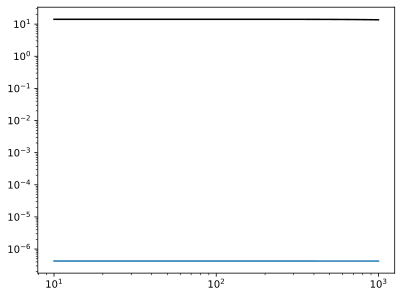

In [8]:
def Transfer_sigma_attractive(v, g=gp, M=mZp ,m=mDM ):
    Beta =  v /(2)
    s = 4 * m**2 / (1 - Beta**2)
    sigma0 = -g**4/(4*np.pi*s**3*Beta**4)

    t_chn = -((s * Beta**2 * (-16 * m**4 - 6 * M**4 + 16 * m**2 * s - M**2 * s * (8 + 3 * Beta**2) + s**2 * (-4 - 4 * Beta**2 + Beta**4))) / (2 * (M**2 + s * Beta**2)))
    t_chn_log = - (8 * m**4 + 3 * M**4 - 8 * m**2 * s + 4 * M**2 * s + 2 * s**2)
    TA_t = t_chn + t_chn_log*np.log(1 + s*Beta**2/M**2)
    
    TA_s = -s**2 * Beta**4 * (24 * m**4 + 4 * m**2 * s * Beta**2 + s**2 * (3 - 2 * Beta**2)) / (6 * (M**2 - s)**2)

    ts_chn = - s*Beta**2 * (-24*m**4 + 6*(M**2 + s)**2 - 3*s*Beta**2*(2*s + M**2) + 2*s**2*Beta**4)/(6*(s-M**2))
    ts_chn_log = M**2 * ((s + M**2)**2 - 4*m**4)/(s-M**2)
    TA_st = ts_chn + ts_chn_log*np.log(1 + s*Beta**2/M**2)

    return fc* sigma0 * (TA_st)/m

crossSection_array = [Transfer_Sigma_Low_Energy(v/c, gp, mZp, mDM) for v in v_array]
crossSection_array_3 = [Transfer_sigma_attractive(v/c) for v in v_array]


plt.plot(v_array, crossSection_array, 'k')
plt.plot(v_array, crossSection_array_3)


plt.xscale('log')
plt.yscale('log')
plt.show()


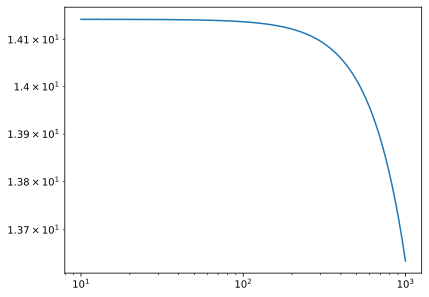

In [19]:


plt.xscale('log')
plt.yscale('log')
plt.show()
